# Sentiment Analysis menggunakan Metode Convolutional Neural Networks

#### Program ini menggunakan pre-trained word embeddings (GloVe embeddings) yang diterapkan pada Keras Embedding layer yang telah digunakan untuk melatih model text classification pada 20 category berbeda pada newsgroup dataset.

#### Pre-trained model GloVe dapat didownload dengan link:
  http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

#### Referensi: klasifikasi teks pada 20 category dari newsgroup dataset dapat diakses melalui:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html


## Import Library yang dibutuhkan

In [1]:
from __future__ import print_function
import os             #memberikan akses read/write data atau manipulasi lokasi path data yang akan digunakan
import sys            #memberikan akses variabel yang digunakan atau dikelola interpreter

import numpy as np              #melakukan perhitungan matrix / array
import pandas as pd             #melakukan manipulasi pada data
from matplotlib import pyplot   #memvisualisasi data

import tensorflow
from tensorflow import keras
from keras import backend as K                          #menggunakan library keras sebagai backend
from keras.preprocessing.text import Tokenizer          #menggunakan modul preprocessing tokenizer dari keras untuk tokenisasi text
from keras.preprocessing.sequence import pad_sequences  #menggunakan modul preprocessing pad_sequences dari keras untuk padding text ke kalimat
from keras.utils import to_categorical                  #menggunakan modul to_categorical untuk categorical data
from keras.models import Model                          #menggunakan modul Model untuk membangun model
from keras.initializers import Constant
from keras.layers import Input, Conv1D, MaxPooling1D, Embedding  #menggunakan modul layers dari keras untuk merancang layer- 
from keras.layers import Dense, GlobalMaxPooling1D, Dropout      #layer / lapisan model CNN

from sklearn.utils import shuffle       #menggunakan modul shuffle dari sklearn untuk shuffling data 
import warnings
warnings.filterwarnings("ignore")       #membiarkan tampilan warnings

Using TensorFlow backend.


### Definisi Fungsi Confusion Matrix

In [2]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Pendefinisian Fungsi Baca Dataset

In [3]:
def read_csv(filepath):
     if os.path.splitext(filepath)[1] != '.csv':
          return  # or whatever
     seps = [',', ';', '\t']                    # ',' is default
     encodings = [None, 'utf-8', 'ISO-8859-1']  # None is default
     for sep in seps:
         for encoding in encodings:
              try:
                  return pd.read_csv(filepath, encoding=encoding, sep=sep)
              except Exception:  # should really be more specific 
                  pass
     raise ValueError("{!r} is has no encoding in {} or seperator in {}"
                      .format(filepath, encodings, seps))

### Set lokasi Dataset

In [4]:
BASE_DIR = 'E:/scriptc/'
GLOVE_DIR = os.path.join(BASE_DIR, 'glovedata')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'spotifydata')
SPOTIFY_REVIEW_FILE_NAME = "tiktok.csv"

### Split Data dan Setting Max Word


In [5]:
VALIDATION_SPLIT = 0.2   #20% untuk validasi data
MAX_SEQUENCE_LENGTH = 1000 
MAX_NUM_WORDS = 20000    #20000 maksimum jumlah kata
EMBEDDING_DIM = 100      # 

### Word Embbeding Vector

In [6]:
# Pertama, membuat mapping index kata pada embedding set ke bentuk embedding vektor 
print('Indexing word vectors....')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Ditemukan sebanyak %s word vectors.' % len(embeddings_index))

Indexing word vectors....
Ditemukan sebanyak 400000 word vectors.


In [7]:
# Kedua, menyiapkan sample text (review) dan labelnya 
print('Processing review dataset....')

texts = []  # list dari sampel text(Review) 
labels_index = {}  # pemetaan kamusdata pada nama label ke bentuk angka
labels = []  # list of label ids

input_df = read_csv(os.path.join(TEXT_DATA_DIR, SPOTIFY_REVIEW_FILE_NAME))  #deklarasi variabel input 

Processing review dataset....


In [8]:
review_df1 = input_df[['review','label']]
review_df = review_df1[review_df1['label']!='unsup']

review_df = shuffle(review_df)   #shuffle data
print("Here are Few Samples in data")
print(review_df.head)

print("Here total number of positive and negative samples")
print(review_df.groupby(['label']).count())

print("Converting pandas dataframe into lists")
texts = review_df['review'].values.tolist()
labels = []
labels_text = []
labels_text_unique = review_df.label.unique().tolist()
labels_text = review_df['label'].values.tolist()

idxCounter = 0
for label in labels_text_unique:
    labels_index[label] = idxCounter
    idxCounter = idxCounter + 1;

idxCounter = 0    
for label in labels_text:
    print("processing row " + str(idxCounter))
    labels.append(labels_index[label])
    idxCounter = idxCounter + 1;
    

print("Labels Array")
print(len(labels))
print("Labels Dictionary")
print(labels_index)
print("Done")

Here are Few Samples in data
<bound method NDFrame.head of                                                 review  label
816  KOK GA BISA DI UPDATE YA?!!! TOLONG PERBAIKI U...      0
504  Tik tok ini sangat bgus dan kita bisa banyak d...      1
676  Ketika gabut, saya bisa melihat video² lucu di...      1
412  Bagus banget kita bisa jadi terkenal sekarang ...      1
622  Saya senang bermain tik tok hanya tik tok lah ...      1
..                                                 ...    ...
277  Saya sangat tertarik dgn tik tok yang banyak s...      1
200  Tik Tok ini sangat kereennn banget. Aku suka b...      1
123  Alasan saya suka dengan aplikasi ini, karena a...      1
85   ini kok apk nya banyak ga bisa fiturnya, pas d...      0
905  Kenapa yg saya ga ada,yg klik.Giliran artis2 y...      0

[1000 rows x 2 columns]>
Here total number of positive and negative samples
       review
label        
0         500
1         500
Converting pandas dataframe into lists
processing row 0
processi

In [9]:

# second, prepare text samples and their labels
#print('Processing text dataset')

#texts = []  # list of text samples
#labels_index = {}  # dictionary mapping label name to numeric id
#labels = []  # list of label ids
#for name in sorted(os.listdir(TEXT_DATA_DIR)):
#    path = os.path.join(TEXT_DATA_DIR, name)
#    if os.path.isdir(path):
#        label_id = len(labels_index)
#        labels_index[name] = label_id
#       for fname in sorted(os.listdir(path)):
#            if fname.isdigit():
#                fpath = os.path.join(path, fname)
#                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
#                with open(fpath, **args) as f:
#                    t = f.read()
#                    i = t.find('\n\n')  # skip header
#                    if 0 < i:
#                        t = t[i:]
#                    texts.append(t)
#                labels.append(label_id)

#print('Found %s texts.' % len(texts))


In [10]:

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Ditemukan sejumlah %s tokens unik.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape dari data tensor:', data.shape)     
print('Shape dari label tensor:', labels.shape)   

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
print(indices)
np.random.shuffle(indices)   #mengacak data index secara random 
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])  #total sampel validasi didapat dari 0.2 * jumlah data pada dataset(1000)

x_train = data[:-num_validation_samples]            #data train review diambil dari awal data ke-1 sampai data ke 800 
y_train = labels[:-num_validation_samples]          #data train label diambil dari awal data ke-1 sampai data ke-800
x_val = data[-num_validation_samples:]              #data validasi review diambil dari awal data ke-801 sampai data ke-1000 
y_val = labels[-num_validation_samples:]            #data validasi label diambil dari awal data ke-801 sampai data ke-1000

Ditemukan sejumlah 2733 tokens unik.
Shape dari data tensor: (1000, 1000)
Shape dari label tensor: (1000, 2)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 21

In [11]:
print(y_val[5])  #cetak contoh sampel data label pada data ke 5 --> data review ke 5 berlabel 1(positif) 

[1. 0.]


In [12]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #kata-kata yang tidak ditemukan pada embedding index akan dijadikan 0 (all-zeros)
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


In [13]:
print('Training model.')

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(512, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(512, 5, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(512, 5, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
#sesudah 0604 ditambah layer lagi
#x = Conv1D(256, 5, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = MaxPooling1D(5)(x)
#x = Conv1D(128, 5, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = MaxPooling1D(5)(x)
#-----

x = Conv1D(512, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(512, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
#adam
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) 
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['acc', f1_m, precision_m, recall_m])



import time
start = time.time()

history = model.fit(x_train, y_train,
          batch_size=200,
          epochs=1,
          validation_data=(x_val, y_val))


print("Lama proses: ", time.time() - start, "detik")

Training model.
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 50s 63ms/step - loss: 0.2588 - acc: 0.4900 - f1_m: 0.4900 - precision_m: 0.4900 - recall_m: 0.4900 - val_loss: 0.2436 - val_acc: 0.5450 - val_f1_m: 0.5450 - val_precision_m: 0.5450 - val_recall_m: 0.5450
Lama proses:  51.654412269592285 detik


In [14]:
model_viz = keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         273400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 512)          256512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 996, 512)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 512)          1311232   
_________________________________________________________________
dropout_2 (Dropout)          (None, 195, 512)          0   

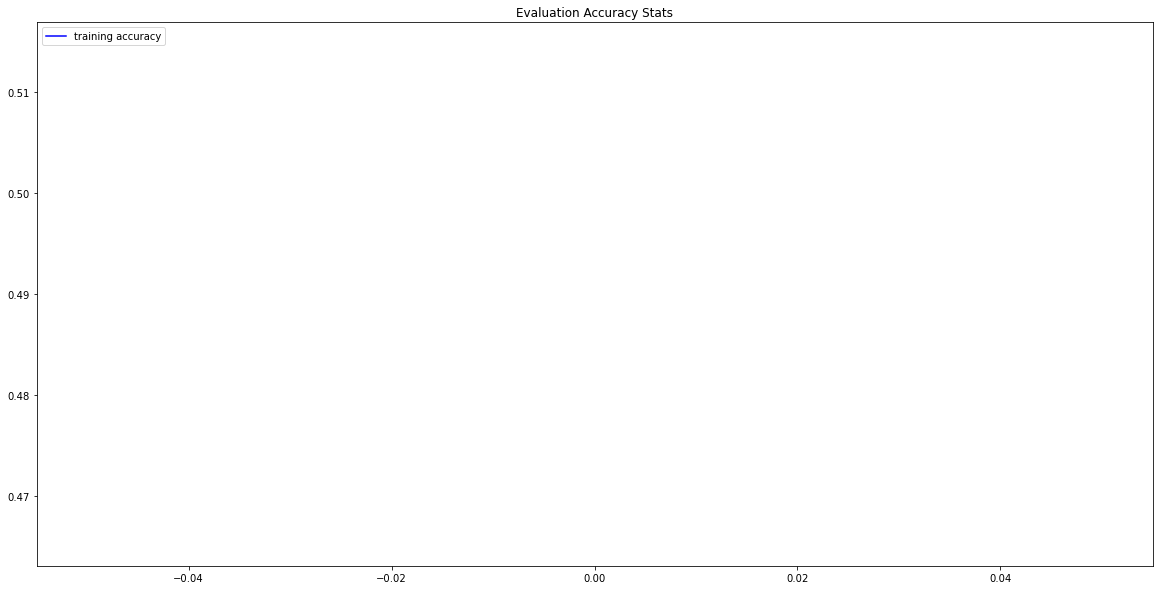

In [16]:
#Visualisai metriks akurasi
pyplot.figure(figsize = (20, 10))
#pyplot.plot(history.history["f1_m"],  label="f1 score", color="grey")
#pyplot.plot(history.history["precision_m"], label="precision", color="black")
#pyplot.plot(history.history["recall_m"], label="recall", color="red")
pyplot.plot(history.history['acc'] , label="training accuracy", color="blue")
pyplot.title('Evaluation Accuracy Stats')
pyplot.legend(loc="upper left")
pyplot.show()

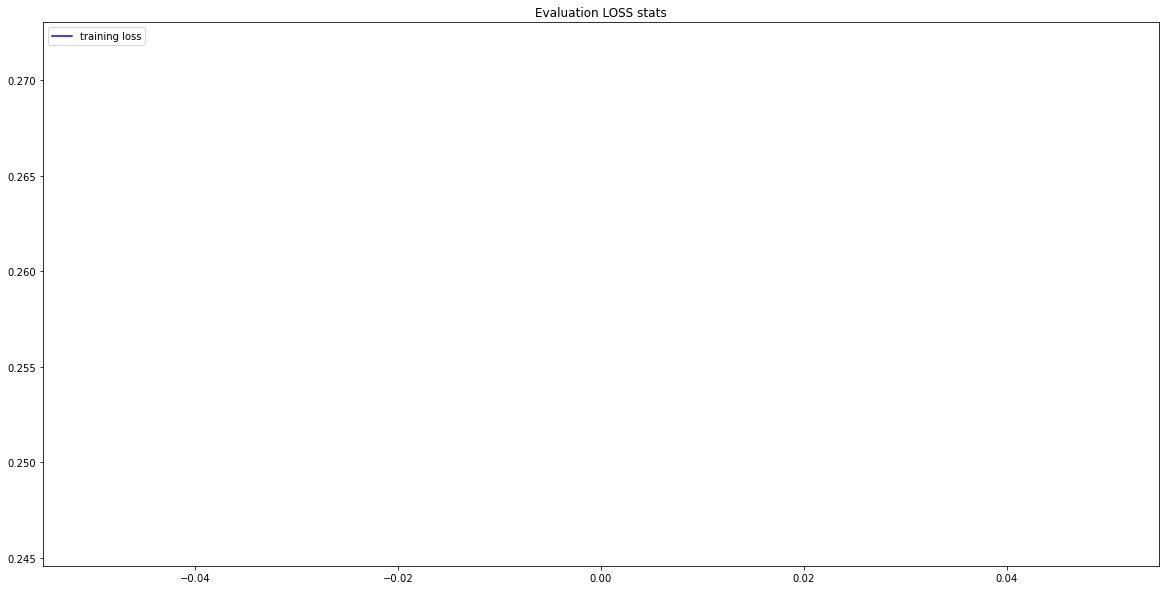

In [17]:
#visualisasi metriks loss
pyplot.figure(figsize = (20, 10))
pyplot.plot(history.history['loss'] , label="training loss", color="blue")
pyplot.title('Evaluation LOSS stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [18]:
#konversi model ke JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
#konversi model ke HDF5
model.save_weights("model.h5")
print("Saved model to disk")



Saved model to disk
